# How to build a machine learning marketing model for banking using Google Cloud Platform and Python

This notebook shows you how to build a marketing model for banking using [Google Cloud Platform](https://cloud.google.com/) (GCP). Many financial institutions use traditional on-premise methods and tooling to build models for marketing. This notebook takes you through the steps to build a Machine Learning model using open source and Google Cloud Platform. Some of the advantages of this approach are:

* Flexibility: The open source models can easily be ported. 
* Scalability: It's easy to scale using the power of Google Cloud.
* Transparency: Lime will give you more insights in the model.
* Ease of use: Pandas and Scikit-learn are easy to use.

We will go into some important topics for modeling within banking, like data exploration and model explanation. This notebook is created so that it can be re-used for migrating workloads to open source and the cloud. We will take you through the following steps:

* Fetching data from [Google BigQuery](https://cloud.google.com/bigquery/)
*   Data Exploration using [Pandas profling](https://github.com/pandas-profiling/pandas-profiling)
*   Data partitioning using [Scikit-learn](http://scikit-learn.org/)
*   Data Engineering
*   Building and evaluating different models
*   Explaining the models using [Lime](https://github.com/marcotcr/lime)
*   Use [Cloud Machine Learning Engine](https://cloud.google.com/ml-engine/) to deploy to model as an API
*   Get predictions


#### Type of model

The goal of this model is to predict if the banking client will subscribe a term deposit, which is variable `y` in our dataset. This class of models are called "propensity to buy" models and this type of problem is binary classification. "*Propensity to buy*"models can help us predict the success of our marketing campaign.

<br>

#### What this notebook will not do

* Teach you the basics of Machine Learning. We focus on how to train and deploy a ML model using the power of Google Cloud. 
* There is not one Cloud solution for all of your business problems. Because we choose Pandas and Scikit-Learn, they both have limitations. We choose to use Pandas + Scikit-learn because it helps making the transition from on-prem solutions to open source and Google Cloud easier. We have other solutions that can help you scale things even further using Google Cloud. 

## Prerequisites
Before we get started we need to go through a couple of prerequisites. 

First, install two packages that your environment may not have (lime and pandas profiling). After running the cell, restart the Kernel by clicking 'Kernel > Restart Kernel' on the top menu.

In [1]:
!pip install pandas-profiling
!pip install lime

*(Only if you are using a colab notebook)* We need to authenticate to Google Cloud and create the service client. After running the cell below, a link will appear which you need to click on and follow the instructions.

Next, we need to set our project. Replace 'PROJECT_ID' with your GCP project ID.

In [4]:
import os
PROJECT_ID = os.environ.get('PROJECT_ID')
STORAGE_ACCOUNT = PROJECT_ID + "-storage"
GCS_BUCKET = "gs://" + STORAGE_ACCOUNT + "/"
DATASET = 'team_dataset'
TABLE = 'uci_bank_' + USER
USER = os.environ.get('JUPYTERHUB_USER').split('.')[0]
%env STORAGE_ACCOUNT = {STORAGE_ACCOUNT}
%env DATASET = {DATASET}
%env TABLE = {TABLE}
%env USER = {USER}

env: STORAGE_ACCOUNT=anz-uc-team-1-storage
env: DATASET=team_dataset
env: TABLE=uci_bank_troy
env: USER=troy


The data that we will be using for this demo is the [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). 

The first step we will need to take is to create a BigQuery dataset and a table so that we can store this data. Make sure that you replace `your_dataset` and `your_table` variables with any dataset and table name you want.

In [5]:
!bq mk -d {PROJECT_ID}:{DATASET}
!bq mk -t {DATASET}.{TABLE}

BigQuery error in mk operation: Dataset 'anz-uc-team-1:team_dataset' already
exists.
BigQuery error in mk operation: Table 'anz-uc-team-1:team_dataset.uci_bank_troy'
could not be created; a table with this name already exists.


There is a public dataset avaliable which has cleaned up some of the rows in the `UCI Bank Marketing Dataset`. We will download this file and save locally as `.team-storage/trainer/bank-full.csv`.

We will now upload the `./team-storage/trainer/bank-full.csv` file into our BigQuery table.

In [6]:
!bq load --autodetect --allow_quoted_newlines -F ";" --skip_leading_rows=1 --replace=true --source_format=CSV {DATASET}.{TABLE} team-storage/trainer/bank-full.csv

Upload complete.
Waiting on bqjob_rf27245d710a084a_0000016dc9962a46_1 ... (0s) Current status: DONE   


## 1) Fetching data 

In this chapter we will get data from BigQuery and create a Pandas dataframe that we will be using for data engineering, data visualization and modeling.

###  Data from BigQuery to Pandas
We are going to use the datalab.bigquery library to fetch data from bigquery and load a Pandas dataframe.

In [7]:
#import pandas and bigquery library

import pandas as pd
from google.cloud import bigquery as bq

We doing two things in this cell:


1.   We are executing an SQL query
2.   We are converting the output from BQ into a pandas dataframe using `.to_dataframe()`



In [8]:
# Execute the query and converts the result into a Dataframe
client = bq.Client(project=PROJECT_ID)
df = client.query('''
  SELECT
    age, job, marital, education, CAST (`default` AS INT64) AS `default`, 
    balance, CAST (housing AS INT64) as housing, CAST (loan AS INT64) as loan, 
    contact, day, month, duration, campaign, pdays, previous, poutcome, CAST(y AS INT64) AS y
  FROM
    `%s.%s`
''' % (DATASET, TABLE)).to_dataframe()

df.head(3).T

,0,1,2
age,42,56,44
job,admin.,admin.,admin.
marital,single,married,married
education,secondary,secondary,secondary
default,0,0,0
balance,-247,1270,4826
housing,1,1,1
loan,1,0,0
contact,telephone,cellular,cellular
day,21,17,17


We will now explore the data we got from BQ

## 2) Data exploration

### Data types

Check the data type of each column in df. 

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null int64
balance      45211 non-null int64
housing      45211 non-null int64
loan         45211 non-null int64
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null int64
dtypes: int64(11), object(6)
memory usage: 5.9+ MB


bool columns should be cast as strings to facilitate data exploration (i.e. not all packages run on columns of type bool).

In [10]:
mask = df.applymap(type) != bool
d = {True: 'TRUE', False: 'FALSE'}

df = df.where(mask, df.replace(d))
df.head(3).T

,0,1,2
age,42,56,44
job,admin.,admin.,admin.
marital,single,married,married
education,secondary,secondary,secondary
default,0,0,0
balance,-247,1270,4826
housing,1,1,1
loan,1,0,0
contact,telephone,cellular,cellular
day,21,17,17


### Summary statistics

Pandas provide several methods for quickly summarising numerical columns. Pandas profiling (below) will be used for more in depth review of all columns.

In [11]:
df.describe()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,y
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,0.018027,1362.272058,0.555838,0.160226,15.806419,258.163080,2.763841,40.197828,0.580323,0.116985
std,10.618762,0.133049,3044.765829,0.496878,0.366820,8.322476,257.527812,3.098021,100.128746,2.303441,0.321406
min,18.000000,0.000000,-8019.000000,0.000000,0.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,0.000000,72.000000,0.000000,0.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,0.000000,448.000000,1.000000,0.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,0.000000,1428.000000,1.000000,0.000000,21.000000,319.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,1.000000,102127.000000,1.000000,1.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


In [12]:
df.hist(figsize=(18,9))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0761314a90>,
      dtype=object)

### Pandas profiling

We will use [Pandas profiling](https://github.com/pandas-profiling/pandas-profiling) to perform data exploration. This will give us information including distributions for each feature, missing values, the maximum and minimum values and many more. These are all out of the box. Run the next cell first if you haven't installed pandas profiling. (Note if after you haved installed pandas profiling, you get an import error, restart your kernel and re-run all the cells up until this section).

In [13]:
import pandas_profiling as pp

In [14]:
# Let's create a Profile Report using the dataframe that we just created. 
pp.ProfileReport(df)

/opt/conda/lib/python3.7/site-packages/pandas_profiling/base.py:319: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,17
Number of observations,45211
Total Missing (%),0.0%
Total size in memory,5.9 MiB
Average record size in memory,136.0 B
Numeric,11
Categorical,6
Date,0
Text (Unique),0
Rejected,0
Distinct count,77


Some interesting points from the pandas profiling:
* We have categorical columns which we need to convert to numeric values
* The predictor value (y) is very skewed (only 5289 took the term deposit compared to a massive 39922 users not taking it) so we need to ensure that our training and testing splits are representative of this skew
* No missing values

### Data visualisation

Though pandas profiling provides a thorough summary, additional visualisation of the data can provide important insight prior to the modelling process. Seaborn is a great package for this purpose.
Note: as the predictor is categorical we cannot compute correlations between the input features and the predictor. Instead we must look to potential indicators of a relationship using the graphs. There are many possible input features. A selection of graph types will be presented below as examples.

In [15]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set(style="ticks", color_codes=True)

%matplotlib inline

The graphs being created will take some time to process the approx 45,000 rows within the current dataset.
We will use a smaller test set for the remaining visualisations.

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=40)
for train_index, test_index in split.split(df, df["y"]):
    strat_test_set = df.loc[test_index]

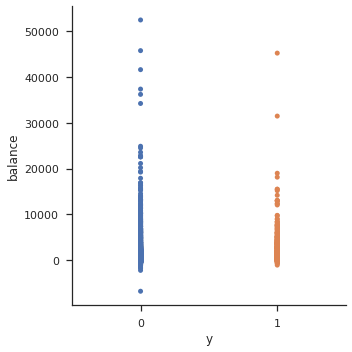

In [17]:
sns.catplot(x="y", y="balance", jitter=False, data=strat_test_set)

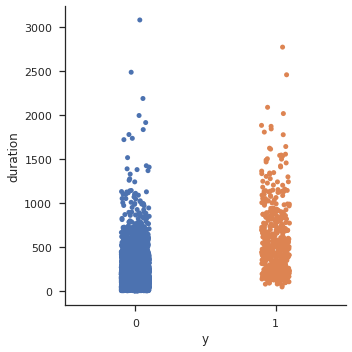

In [18]:
sns.catplot(x="y", y="duration", data=strat_test_set)

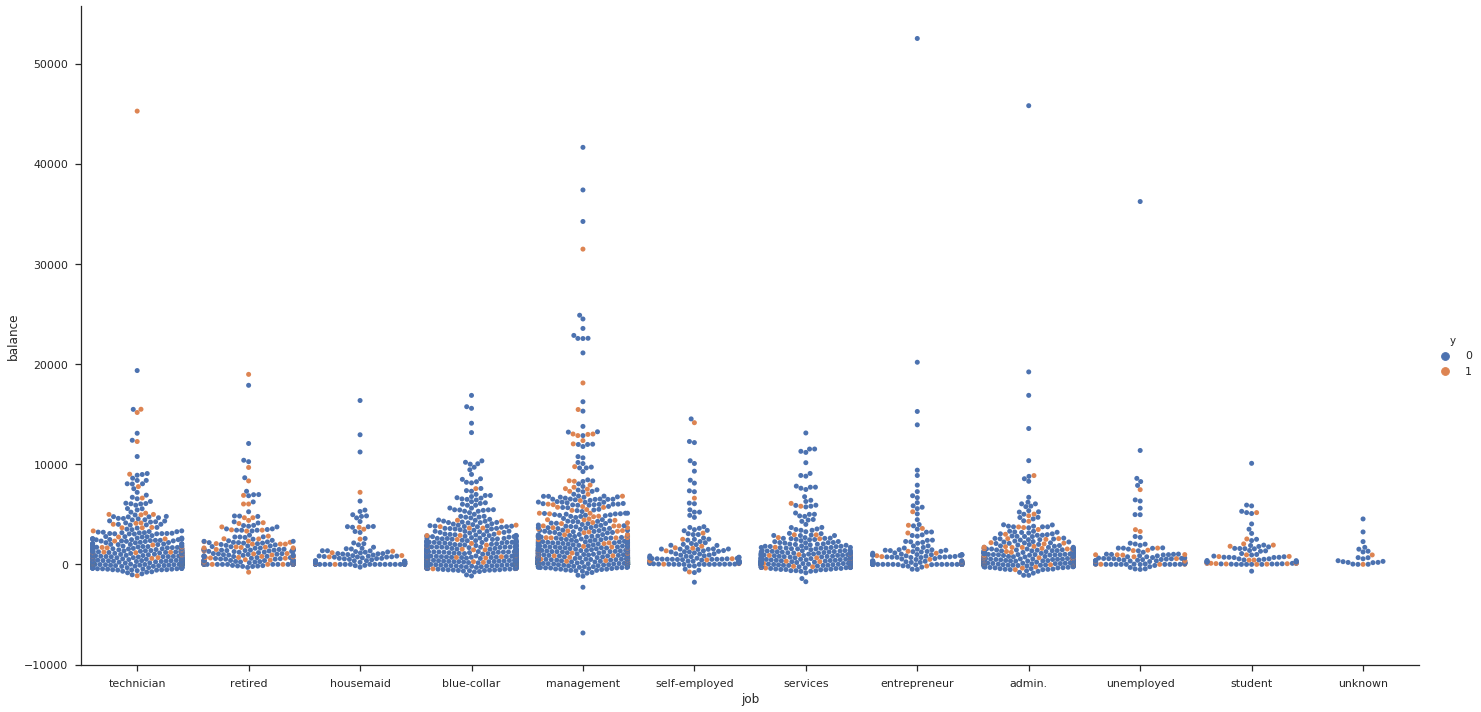

In [19]:
sns.catplot(x="job", y="balance", hue="y", kind="swarm", data=strat_test_set, height=10, aspect=2)

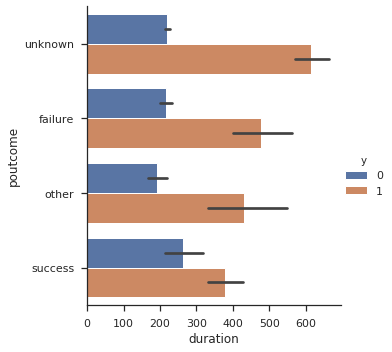

In [20]:
sns.catplot(x="duration", y="poutcome", hue="y", kind="bar", data=strat_test_set)

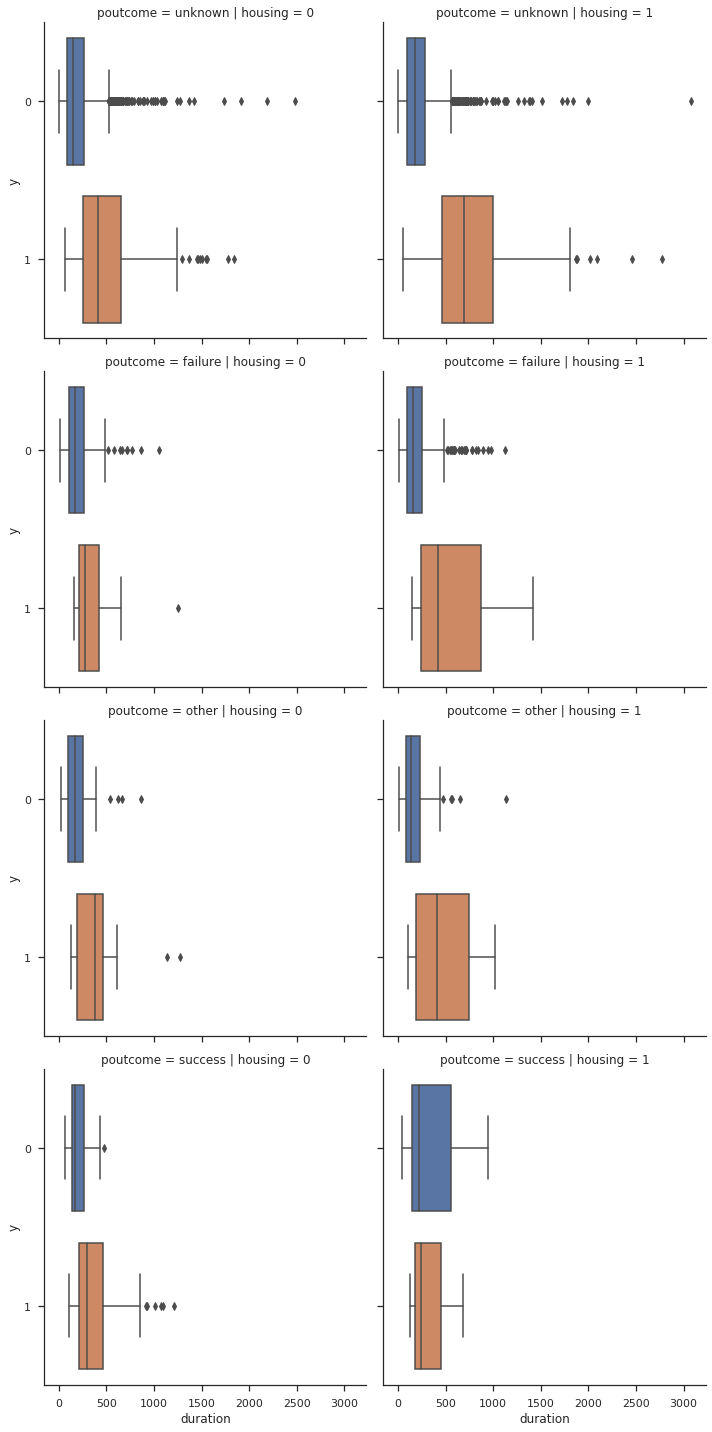

In [21]:
sns.catplot(x="duration", y="y", row="poutcome", col="housing",
            kind="box", orient="h", data=strat_test_set)

matplotlib also be used.

NameError: name 'ax' is not defined

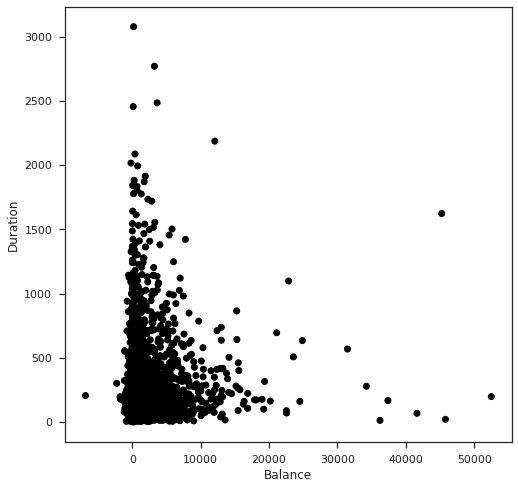

In [22]:
cmap = {'TRUE': 'orange', 'FALSE': 'blue'}
fig = plt.figure(figsize=(8,8))
plt.scatter(strat_test_set.balance, strat_test_set.duration,  
    c=[cmap.get(c, 'black') for c in strat_test_set.y])
plt.xlabel("Balance")
plt.ylabel("Duration")
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels)
plt.show()

Even with this small selection of graphs it is possible to gain insight into potential relationships. For example, duration (last contact duration, in seconds) appears to affect whether the customer has taken the term deposit product. Generally the call duration is much longer with the notable exception being when a customer has taken the product during the previous campaign and has a housing loan.

These graphs serve as examples. Additional combinations should be examined to ensure thorough exploration of the data.

## 3) Data partitioning (split data into training and testing)

As our dataset is highly skewed, we need to be very careful with our sampling approach. Two things need to be considered: 

1.   Shuffle the dataset to avoid any form of pre-ordering.
2.   Use [stratified sampling](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) (SE). SE makes sure that both datasets (test, training) do not significantly differ for variables of interest. In our case we use SE to achieve a similar distribution of `y` for both datasets.



In [23]:
from sklearn.model_selection import StratifiedShuffleSplit

#Here we apply a shuffle and stratified split to create a train and test set.
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=40)
for train_index, test_index in split.split(df, df["y"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [24]:
# check the split sizes

print(strat_train_set.size)
print(strat_test_set.size)

614856
153731


In [25]:
# We can now check the data
strat_test_set.head(3).T

,26627,804,17565
age,29,46,49
job,management,management,services
marital,single,married,married
education,tertiary,secondary,secondary
default,0,0,0
balance,307,1098,-507
housing,1,0,0
loan,0,0,0
contact,cellular,cellular,telephone
day,2,8,28


## 4) Data preparation (feature engineering)

Before we can create Machine Learning models, we need to format the data so that it is in a form that the models can understand.

We need to do the following steps:

1.   For the numeric columns, we need to normalize these columns so that one column with very large values does not bias the computation.
2.   Turn categorical values into numeric values replacing each unique value in a column with an integer. For example, if a column named "Colour" has three unique strings "red", "yellow" and "blue" they will be assigned the values 0, 1 and 2 respectively. So each instance of yellow in that column will be replaced with 0. Note: [one hot encoding](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) is an alternative method to convert categorical values to integers.
3.   For True/False values we simply convert these to 1/0 respectively.



In [26]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

Now we are going to ceate a function to split the label we want to predict and the feature that we will use to predict this value. In addition, we convert the label to 1/0.

In [27]:
def return_features_and_label(df):
    """returns features and labal given argument dataframe"""
    
    # Get all the columns except "y". It's also possible to exclude other columns
    X = df.drop("y", axis=1)
    
    Y = df["y"].copy ()
    # Convert our label to an integer
    Y = LabelEncoder().fit_transform(Y) 
    return X, Y

In [28]:
train_features, train_label = return_features_and_label(strat_train_set)

Our training dataset, `train_features`, contains both categorical and numeric values. However, we know that machine learning models can only use numeric values. The function below converts categorical variables to integers and then normalizes the current numeric columns so that certain columns with very large numbers would not over-power those columns whose values are not so large.

In [29]:
def data_pipeline(df):
    """Normalizes and converts data and returns dataframe """
  
    num_cols = df.select_dtypes(include=np.number).columns
    cat_cols = list(set(df.columns) - set(num_cols))
    # Normalize Numeric Data
    df[num_cols] = StandardScaler().fit_transform(df[num_cols])
    # Convert categorical variables to integers
    df[cat_cols] = df[cat_cols].apply(LabelEncoder().fit_transform)
    return df

In [30]:
train_features_prepared = data_pipeline(train_features)

In [31]:
train_features_prepared.head(3).T

,14217,27492,18251
age,-0.271979,1.326772,-0.648155
job,8.000000,9.000000,7.000000
marital,2.000000,1.000000,2.000000
education,3.000000,1.000000,1.000000
default,-0.134749,-0.134749,-0.134749
balance,-0.207265,-0.351958,0.876312
housing,-1.119078,0.893593,0.893593
loan,-0.437069,-0.437069,2.287966
contact,2.000000,2.000000,0.000000
day,0.267121,-0.455160,-0.094020


Some columns in our training dataset may not be very good predictors. This means that we should perform feature selection to get only the best predictors and reduce our time for training since our dataset will be much smaller.

In [32]:
from sklearn.feature_selection import SelectKBest, f_classif  

predictors = train_features_prepared.columns

# Perform feature selection where `k` (5 in this case) indicates the number of features we wish to select
selector = SelectKBest(f_classif, k=5)
selector.fit(train_features_prepared[predictors], train_label) 

SelectKBest(k=5, score_func=<function f_classif at 0x7f075d3f49d8>)

To visualize the selection, we can plot a graph to look at the scores for each feature. Note that the `duration` feature had 0 as its p-value and so it could not be shown in the logarithmic scale.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


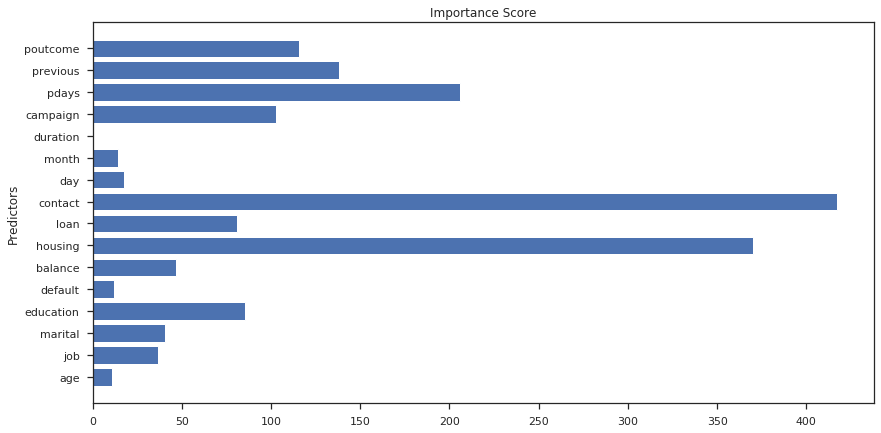

In [33]:
# Get the p-values from our selector for each model and convert to a logarithmic scale for easy vizualization
importance_score = -np.log(selector.pvalues_)

# Plot each column with their importance score
plt.rcParams["figure.figsize"] = [14,7]
plt.barh(range(len(predictors)), importance_score, color='C0')
plt.ylabel("Predictors")
plt.title("Importance Score")
plt.yticks(range(len(predictors)), predictors)

plt.show()

It's also possible to use a Tree classifier to select the best features. It's often a good option when you have a highly imbalanced dataset. 

In [34]:
# Example of how to use a Tree classifier to select best features. 

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel    

predictors_tree = train_features_prepared.columns

selector_clf = ExtraTreesClassifier(n_estimators=50, random_state=0)
selector_clf.fit(train_features_prepared[predictors], train_label) 

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
                     oob_score=False, random_state=0, verbose=0,
                     warm_start=False)

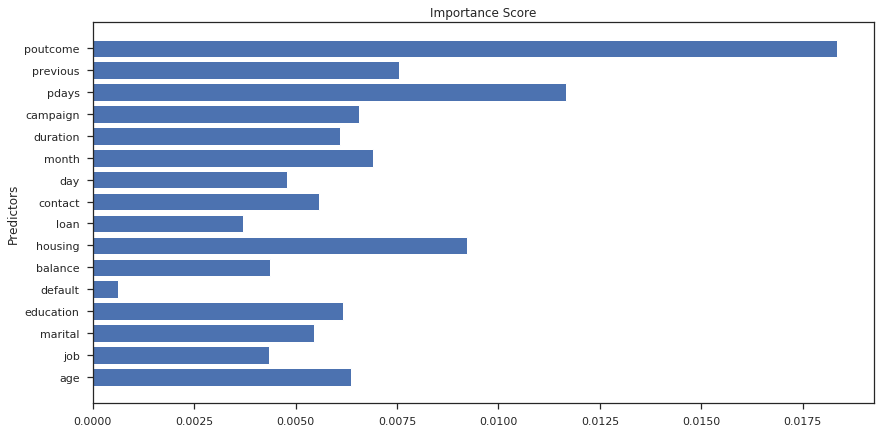

In [35]:
# Plotting feature importance

importances = selector_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in selector_clf.estimators_],
             axis=0)

plt.rcParams["figure.figsize"] = [14,7]
plt.barh(range(len(predictors_tree)), std, color='C0')
plt.ylabel("Predictors")
plt.title("Importance Score")
plt.yticks(range(len(predictors_tree)), predictors_tree)

plt.show()

The plot sometimes may be difficult to know which are the top five features. We can display a simple table with the top selected features and their scores. We are using `SelectKBest` with `f_classif`. 

In [36]:
# Plot the top 5 features based on the Log Score that we calculated earlier.  
train_prepared_indexs = [count for count, selected in enumerate(selector.get_support()) if selected == True]

pd.DataFrame(
    {'Feature' : predictors[train_prepared_indexs],
     'Original Score': selector.pvalues_[train_prepared_indexs],
     'Log Score' : importance_score[train_prepared_indexs]
    }
)

,Feature,Original Score,Log Score
0,housing,1.375125e-161,370.397656
1,contact,7.567334e-182,417.046646
2,duration,0.000000e+00,inf
3,pdays,3.376512e-90,206.015815
4,previous,1.223846e-60,137.953107


Let us now create a training dataset that contains the top 5 features.

In [37]:
# Here we are creating our new dataframe based on the selected features (from selector)
train_prepared_columns = [col for (selected, col) in zip(selector.get_support(), predictors) if selected == True]
train_prepared = train_features_prepared[train_prepared_columns]

## 5) Building and evaluation the models

In this section we will be building models using [Scikit-Learn](http://scikit-learn.org/stable/). We show how [hyper parameter tuning / optimization](https://en.wikipedia.org/wiki/Hyperparameter_optimization) and model evaluation can be used to select the best model for deployment.

In [38]:
# Importing libraries needed

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve


import matplotlib.pyplot as plt
import numpy as np

The following code defines different hyperparameter combinations. More precisely, we define different model types (e.g., Logistic Regression, Support Vectors Machines (SVC)) and the corresponding lists of parameters that will be used during the optimization process (e.g., different kernel types for SVM).

In [39]:
# this function will create the classifiers (models) that we want to test
def create_classifiers(): 
    """Create classifiers and specify hyper parameters"""
    
    log_params = [{'penalty': ['l1', 'l2'], 'C': np.logspace(0, 4, 10)}]

    knn_params = [{'n_neighbors': [3, 4, 5]}]

    svc_params = [{'kernel': ['linear', 'rbf'], 'probability': [True]}]

    tree_params = [{'criterion': ['gini', 'entropy']}]

    forest_params = {'n_estimators': [1, 5, 10]}

    mlp_params = {'activation': [
                    'identity', 'logistic', 'tanh', 'relu'
                  ]}

    ada_params = {'n_estimators': [1, 5, 10]}

    classifiers = [
        ['LogisticRegression', LogisticRegression(random_state=42),
         log_params],
        ['KNeighborsClassifier', KNeighborsClassifier(), knn_params],
        ['SVC', SVC(random_state=42), svc_params],
        ['DecisionTreeClassifier',
         DecisionTreeClassifier(random_state=42), tree_params],
        ['RandomForestClassifier',
         RandomForestClassifier(random_state=42), forest_params],
        ['MLPClassifier', MLPClassifier(random_state=42), mlp_params],
        ['AdaBoostClassifier', AdaBoostClassifier(random_state=42),
         ada_params],
        ]

    return classifiers


After defining our hyperparameters, we use sklearn's [grid search](http://scikit-learn.org/stable/modules/grid_search.html) to iterate through the different combinations of hyperparameters and return the best parameters for each model type. Furthermore, we use [crossvalidation](http://scikit-learn.org/stable/modules/cross_validation.html), pruning the data into smaller subsets (see [K-fold cross validation](https://www.cs.cmu.edu/~schneide/tut5/node42.html)).

In [40]:
# this grid search will iterate through the different combinations and returns the best parameters for each model type. 
# Running this cell might take a while

def grid_search(model, parameters, name,training_features, training_labels):
    """Grid search that returns best parameters for each model type"""
    
    clf = GridSearchCV(model, parameters, cv=3, refit = 'f1',
                       scoring='f1', verbose=0, n_jobs=4)
    clf.fit(training_features, training_labels)
    best_estimator = clf.best_estimator_
  
    return [name, str(clf.best_params_), clf.best_score_,
            best_estimator]

Finally, we define a process enabling us to return the best configuration for each model using cross-validation (the best model is selected based on its F1-score).

In [41]:
# Now we want to get the best configuration for each model. 

def best_configuration(classifiers, training_features, training_labels):
    """returns the best configuration for each model"""
    
    clfs_best_config = []

    for (name, model, parameters) in classifiers:
        clfs_best_config.append(grid_search(model, parameters, name,
                                training_features, training_labels))
    return clfs_best_config

In [42]:
# Here we call the Grid search and Best_configuration function (note we only use 100 rows to decrease the run time). 

import warnings
warnings.filterwarnings('ignore')

classifiers = create_classifiers()
clfs_best_config = best_configuration(classifiers, train_prepared[:100], train_label[:100])

### Evaluation of model performance



In order to choose the best performing model, we shall compare each of the models on the held-out test dataset.

In [43]:
# Prepare the test data for prediction
test_features, test_label = return_features_and_label(strat_test_set)
test_features_prepared = data_pipeline(test_features)
test_prepared = test_features_prepared[train_prepared_columns]

### Model comparison

To compare the performance of different models we create a table with different metrics.

In [44]:
f1_score_list = []
accuracy_list = []
precision_list = []
recall_list = []
roc_auc_list = []
model_name_list = []

# Iterate through the different model combinations to calculate perf. metrics.

for name, params, score, model in clfs_best_config:
    pred_label = model.predict(test_prepared) # Predict outcome.
    f1_score_list.append(f1_score(test_label,pred_label)) # F1 score.
    accuracy_list.append(accuracy_score(test_label, pred_label)) # Accuracy score.
    precision_list.append(precision_score(test_label, pred_label)) # Precision score.
    recall_list.append(recall_score(test_label, pred_label)) # Recall score.
    roc_auc_list.append(roc_auc_score(test_label,
                        model.predict_proba(test_prepared)[:, 1]))  # Predict probability.
    model_name_list.append(name)

# Sum up metrics in a pandas data frame.
pd.DataFrame(
    {'Model' : model_name_list,
     'F1 Score' : f1_score_list,
     'Accurary': accuracy_list,
     'Precision': precision_list,
     'Recall': recall_list,
     'Roc_Auc': roc_auc_list 
    },
    columns = ['Model','F1 Score','Precision','Recall', 'Accurary', 'Roc_Auc']
)

,Model,F1 Score,Precision,Recall,Accurary,Roc_Auc
0,LogisticRegression,0.343826,0.478114,0.268431,0.880128,0.822989
1,KNeighborsClassifier,0.356797,0.413450,0.313800,0.867632,0.695347
2,SVC,0.268326,0.500000,0.183365,0.883003,0.746609
3,DecisionTreeClassifier,0.334408,0.326146,0.343100,0.840208,0.624587
4,RandomForestClassifier,0.292842,0.343511,0.255198,0.855800,0.729608
5,MLPClassifier,0.344583,0.461173,0.275047,0.877585,0.801335
6,AdaBoostClassifier,0.449021,0.479100,0.422495,0.878691,0.810856


### Graphical comparison

For the graphical representation of model performance we use roc curves to highlight the True Positive Rate (TPR), also known as recall, and the False Positive Rate (FPR).

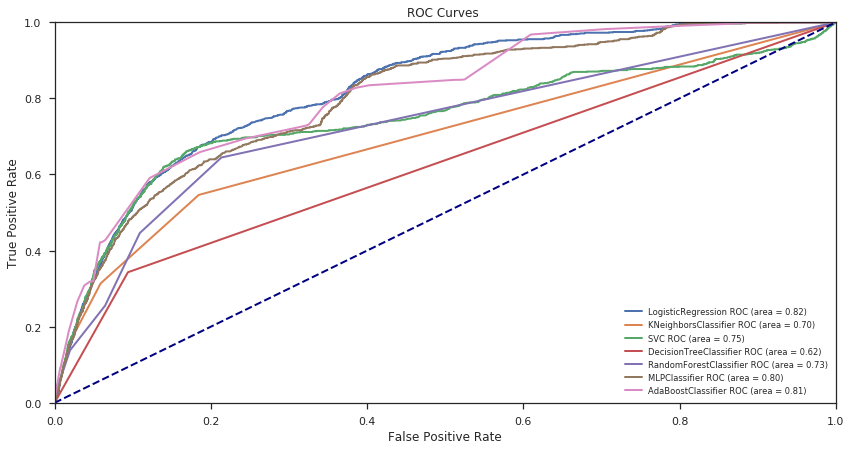

In [45]:
# Create a function that plots an ROC curve
def roc_graph(test_label, pred_label, name):
  """Plots the ROC curve's in a Graph"""
  
  fpr, tpr, thresholds = roc_curve(test_label, pred_label, pos_label=1)
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, lw=2, label='%s ROC (area = %0.2f)' % (name, roc_auc))

plt.clf()

# Iterate though the models, create ROC graph for each model.
for name, _, _, model in clfs_best_config:
    pred_label = model.predict_proba(test_prepared)[:,1]
    roc_graph(test_label, pred_label, name)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves ')
plt.legend(loc="lower right", fontsize='small')
plt.show()

Now that we have all these evaluation metrics, we can select a model based on which metrics we want out models to maximize or minimize.

## 6) Explaning the model

We use the python package [LIME](https://github.com/marcotcr/lime) to explain the model and so we will move from our use of pandas to numpy matrices since this is what LIME accepts.

In [46]:
import lime.lime_tabular
import lime
import sklearn
import pprint

The first thing we will do is to get the unique values from our label.

In [47]:
class_names = strat_train_set["y"].unique()

We need a dataset with our top 5 features but with the categorical values still present. This will allow LIME to know how it should display our features. E.g. using our column example earlier, it will know to display "yellow" whenever it sees a 0.

In [48]:
train = train_features[train_prepared_columns].values

LIME needs to know the index of each catergorical column.

In [49]:
num_cols = train_features._get_numeric_data().columns
cat_cols = list(set(train_features.columns) - set(num_cols))

categorical_features_index = [i for i, val in enumerate(train_prepared_columns) if val in cat_cols]

In addition, LIME requires a dictionary which contains the name of each column and the unique values for each column.

In [50]:
categorical_names = {}
for feature in categorical_features_index:
    # We still need to convert catergorical variables to integers
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(train[:, feature])
    train[:, feature] = le.transform(train[:, feature])
    categorical_names[feature] = le.classes_
    

Create a function that will return the probability that the model (in our case we chose the logistic regression model) selects a certain class.

In [51]:
predict_fn = lambda x: clfs_best_config[0][-1].predict_proba(x).astype(float)

Use the LIME package to configure a variable that can be used to explain predicitons.

In [52]:
explainer = lime.lime_tabular.LimeTabularExplainer(train, feature_names=train_prepared_columns,class_names=class_names,
                                                   categorical_features=categorical_features_index, 
                                                   categorical_names=categorical_names, kernel_width=3)

When you would like to understand the prediction of a value in the test set, create an explanation instance and show the result.

[('previous <= -0.24', -0.23731294096234165),
 ('contact <= 0.00', 0.09430563563624784),
 ('duration <= -0.60', -0.08875710227318151),
 ('-1.12 < housing <= 0.89', -0.06777206254545269),
 ('pdays <= -0.41', 0.021667038278543365)]


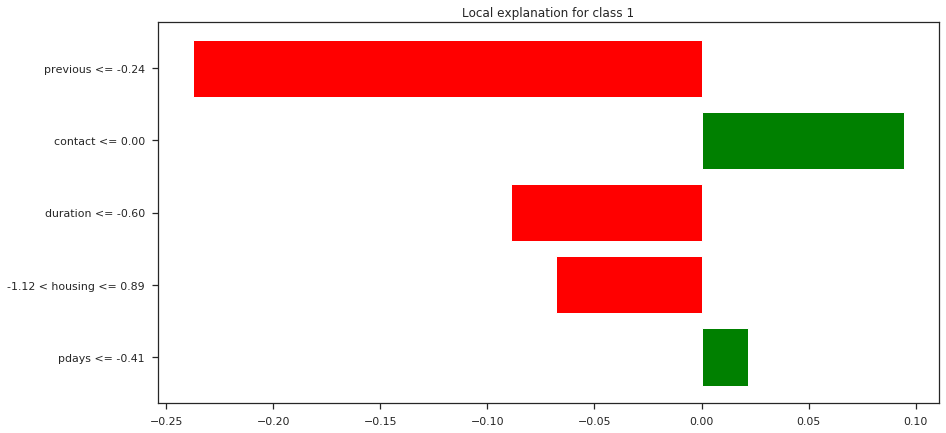

In [53]:
i = 106
exp = explainer.explain_instance(train[i], predict_fn)
pprint.pprint(exp.as_list())
fig = exp.as_pyplot_figure()

## 7) Train and Predict with Cloud Machine Learning Engine

We just saw how to train and predict our models locally. However, when we want more compute power or want to put our model in production serving 1000s of requests, we can use [Cloud Machine Learning Engine](https://cloud.google.com/ml-engine/docs/scikit/) to perform these tasks.

Let us define some environment variables that CMLE uses. Do not forget to replace all the variables in square brackets (along with the square brackets) with your credentials.

In [ ]:
%env REGION=asia-east1
%env LOCAL_DIRECTORY=./trainer/data
%env TRAINER_PACKAGE_PATH=./trainer

ML Engine needs a Python package with our code to train models. 
You could find prepared code and training data in `team-storage/trainer` folder.

To actully run the `trainer/task.py` file we need some parameters so that CMLE knows 
how to set up the environment to run successfully.

In [ ]:
from datetime import datetime
now = datetime.now()
JOBNAME='banking_' + now.strftime("%y%m%d_%H%M%S")
%env JOBNAME = {JOBNAME}

In [ ]:
%%bash 

echo $JOBNAME

gcloud ml-engine jobs submit training model_training_$JOBNAME \
        --job-dir gs://$STORAGE_ACCOUNT/$JOBNAME/output \
        --package-path trainer \
        --module-name trainer.task \
        --region $REGION \
        --runtime-version=1.9 \
        --python-version=3.5 \
        --scale-tier BASIC -- $STORAGE_ACCOUNT

The above cell submits a job to CMLE which you can view by going to the Google Cloud Console's sidebar and select `AI Platform > Jobs`. 
ONLY run the cells below after your job has completed successfully. (It should take approximately 8 minutes to run).





---



Now that we have trained our model and it is saved in GCS we need to perform prediction. There are two options available to use for prediction:

1.   Command Line
2.   Python



In [ ]:
test_features_prepared = data_pipeline(test_features)
test_prepared = test_features_prepared[train_prepared_columns]
test = test_prepared.as_matrix().tolist()

Just like training in CMLE, we set some environment variables when we run our command line commands. Note that `<MODEL_DIRECTORY>` can be found in your bucket, it will be of the form `model_YYYYMMDD_HHMMSS` (e.g. `model_190114_134228`).

In [ ]:
%env VERSION_NAME=v1
%env MODEL_NAME=model1111
%env JSON_INSTANCE=input.json
%env MODEL_DIR=gs://$STORAGE_ACCOUNT/model_<YYYMMDD>_<HHMMSS>
%env FRAMEWORK=SCIKIT_LEARN

Create a model resource for your model versions as well as the version.

In [ ]:
! gcloud ml-engine models create $MODEL_NAME --regions=us-east1

In [ ]:
! gcloud ml-engine versions create $VERSION_NAME \
        --model $MODEL_NAME --origin $MODEL_DIR \
        --runtime-version 1.9 --framework $FRAMEWORK \
        --python-version 3.5

For prediction, we will upload a file with one line in our GCS bucket.

In [ ]:
import json
with open('input.json', 'w') as outfile:
  json.dump(test[0], outfile)

In [ ]:
!gsutil cp input.json 'gs://{STORAGE_ACCOUNT}/'

We are now ready to submit our file to get a preditcion.

In [ ]:
! gcloud ml-engine predict --model $MODEL_NAME \
        --version $VERSION_NAME \
        --json-instances $JSON_INSTANCE

We can also use python to perform predictions. See the cell below for a simple way to get predictions using python.

In [ ]:
import googleapiclient.discovery
import os
import pandas as pd

PROJECT_ID = os.environ['PROJECT_ID']
VERSION_NAME = os.environ['VERSION_NAME']
MODEL_NAME = os.environ['MODEL_NAME']

# Create our CMLE service
service = googleapiclient.discovery.build('ml', 'v1')
name = 'projects/{}/models/{}'.format(PROJECT_ID, MODEL_NAME)
name += '/versions/{}'.format(VERSION_NAME)

# Iterate over the first 10 rows of our test dataset
results = []
for data in test[:10]:
    # Send a prediction request 
    responses = service.projects().predict(
        name=name,
        body={"instances": [data]}
    ).execute()

    if 'error' in responses:
        raise RuntimeError(response['error'])
    else:
        results.extend(responses['predictions'])

for i, response in enumerate(results):
    print('Prediction: {}\tLabel: {}'.format(response, test_label[i]))


Copyright 2019 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License